# Import libraries

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load data

In [157]:
df = pd.read_csv('df_model.csv', parse_dates=['Adjusted_Date'])

# Split data into in-sample and out-of-sample sets
train_set = df[df['Adjusted_Date'] < '2025-08-01']
test_set = df[df['Adjusted_Date'] >= '2025-08-01']

# Separate features and target variable
X_train = train_set.drop(columns=['PSEI_Close'])
y_train = train_set['PSEI_Close']
X_test = test_set.drop(columns=['PSEI_Close'])
y_test = test_set['PSEI_Close']

# Define forecast error measure

In [158]:
# Define forecast error measure
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define variable set

In [159]:
# Sentiment columns sets (example)
column_sets = [
    ['negative_score_mean', 'neutral_score_mean', 'positive_score_mean'],
    ['negative_score_sd', 'neutral_score_sd', 'positive_score_sd'],
    ['negative_score_min', 'neutral_score_min', 'positive_score_min'],
    ['negative_score_max', 'neutral_score_max', 'positive_score_max']
]

# No neutral scores
column_sets_no_neutral = [
    ['negative_score_mean', 'positive_score_mean'],
    ['negative_score_sd', 'positive_score_sd'],
    ['negative_score_min', 'positive_score_min'],
    ['negative_score_max', 'positive_score_max']
]

# Linear regression

## Trend model

In [160]:
# Set up for linear regression modeling
results = []
results_coef = []

time_train = np.arange(len(y_train)).reshape(-1,1)
time_test = np.arange(len(y_test)).reshape(-1,1)

for cols in column_sets:
    key = 'reg_trend: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols].copy()
    X_train_cols['time_index'] = time_train
    X_test_cols = X_test[cols].copy()
    X_test_cols['time_index'] = time_test
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- Baseline model: intercept + time index -----
X_baseline_train = sm.add_constant(time_train)
X_baseline_test = sm.add_constant(time_test)

model_baseline = sm.OLS(y_train, X_baseline_train).fit()
y_train_pred_baseline = model_baseline.predict(X_baseline_train)
y_test_pred_baseline = model_baseline.predict(X_baseline_test)

results.append({
    "model": "reg: baseline_trend",
    "coef": model_baseline.params.to_dict(),
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})


In [161]:
# Initialize results list
results_noneutral = []

for cols in column_sets_no_neutral:
    key = 'reg_trend: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols].copy()
    X_train_cols['time_index'] = time_train
    X_test_cols = X_test[cols].copy()
    X_test_cols['time_index'] = time_test
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- Baseline model: intercept + time index -----
X_baseline_train = sm.add_constant(time_train)
X_baseline_test = sm.add_constant(time_test)

model_baseline = sm.OLS(y_train, X_baseline_train).fit()
y_train_pred_baseline = model_baseline.predict(X_baseline_train)
y_test_pred_baseline = model_baseline.predict(X_baseline_test)

results_noneutral.append({
    "model": "reg: baseline_trend",
    "coef": model_baseline.params.to_dict(),
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})

## Non-trend

In [162]:
# Set up for linear regression modeling

for cols in column_sets:
    key = 'reg: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

In [163]:
# Initialize results list

for cols in column_sets_no_neutral:
    key = 'reg: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ARIMA

## Identify AR term

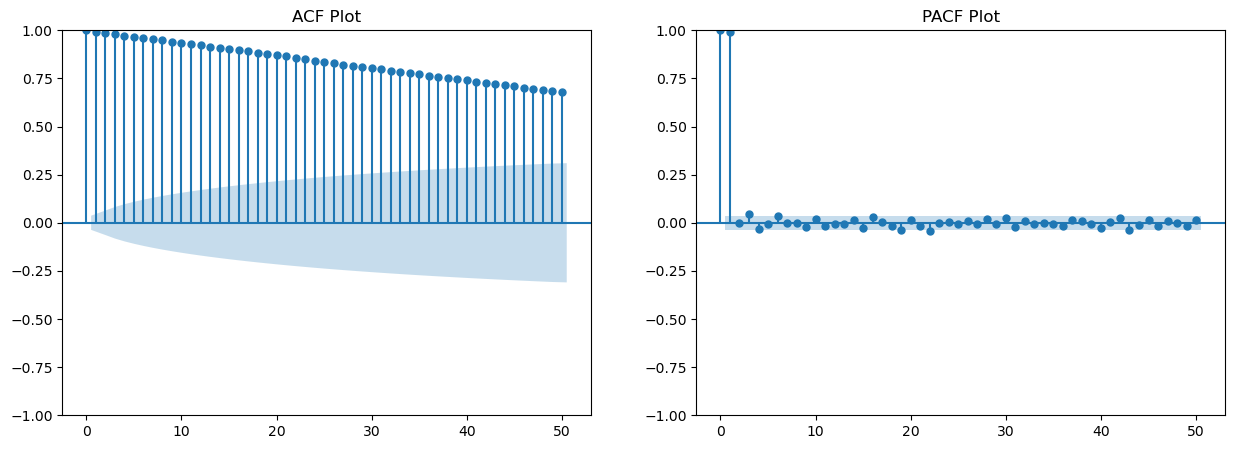

In [164]:
# Locate ideal AR term using ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF plot
plot_acf(y_train, lags=50, ax=axes[0])
axes[0].set_title('ACF Plot')

# PACF plot
plot_pacf(y_train, lags=50, ax=axes[1])
axes[1].set_title('PACF Plot')

plt.show()

## Idenitfy differencing term

In [165]:
result_adf = adfuller(df['PSEI_Close'])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

ADF Statistic: -2.84475892902403
p-value: 0.052159224685149705


In [166]:
df['PSEI_diff1'] = df['PSEI_Close'].diff().dropna()
result_adf2 = adfuller(df['PSEI_diff1'].dropna())
print('ADF Statistic after 1st difference:', result_adf2[0])
print('p-value:', result_adf2[1])


ADF Statistic after 1st difference: -25.01663206472803
p-value: 0.0


## Modeling ARIMA (2,1,1)

In [167]:
# ARIMA order
arima_order = (2,1,1)   

for cols in column_sets:
    key = 'ARIMA: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Fit model
    model_arima = ARIMA(endog=y_train_vals, exog=X_train_cols, order=arima_order)
    model = model_arima.fit()

    # Predictions
    y_train_pred = model.predict(start=0, end=len(y_train_vals)-1, exog=X_train_cols)
    y_test_pred = model.get_forecast(steps=len(y_test_vals), exog=X_test_cols).predicted_mean

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": model.params,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- ARIMA Baseline model -----
model_baseline = ARIMA(endog=y_train, order=arima_order).fit()
y_train_pred_baseline = model_baseline.predict(start=0, end=len(y_train)-1)
y_test_pred_baseline = model_baseline.get_forecast(steps=len(y_test)).predicted_mean

results.append({
    "model": "ARIMA: base",
    "coef": model_baseline.params,
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})

In [168]:
# ARIMA order
arima_order = (2,1,1)   

for cols in column_sets_no_neutral:
    key = 'ARIMA: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Fit model
    model_arima = ARIMA(endog=y_train_vals, exog=X_train_cols, order=arima_order)
    model = model_arima.fit()

    # Predictions
    y_train_pred = model.predict(start=0, end=len(y_train_vals)-1, exog=X_train_cols)
    y_test_pred = model.get_forecast(steps=len(y_test_vals), exog=X_test_cols).predicted_mean

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": model.params,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- ARIMA Baseline model -----
model_baseline = ARIMA(endog=y_train, order=arima_order).fit()
y_train_pred_baseline = model_baseline.predict(start=0, end=len(y_train)-1)
y_test_pred_baseline = model_baseline.get_forecast(steps=len(y_test)).predicted_mean

results_noneutral.append({
    "model": "ARIMA: base",
    "coef": model_baseline.params,
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})

In [169]:
# Display first 5 rows of X_train_reshaped
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("First 5 samples:\n", X_train_reshaped[:5])

Shape of X_train_reshaped: (2820, 5, 1)
First 5 samples:
 [[[9.86565769e-01]
  [9.91232932e-01]
  [9.47892308e-01]
  [5.98272119e+03]
  [5.94640088e+03]]

 [[9.93588448e-01]
  [9.77388501e-01]
  [9.52944875e-01]
  [5.94640088e+03]
  [5.98427148e+03]]

 [[9.90554750e-01]
  [9.75035727e-01]
  [9.90119815e-01]
  [5.98427148e+03]
  [5.94591113e+03]]

 [[9.52285111e-01]
  [9.77106869e-01]
  [9.76323068e-01]
  [5.94591113e+03]
  [5.98494092e+03]]

 [[9.83294249e-01]
  [9.65385675e-01]
  [9.88738894e-01]
  [5.98494092e+03]
  [5.93598340e+03]]]


# LSTM

In [170]:
# Define data lag function
def create_lagged_matrix(y, n_lags):
    X, y_out = [], []
    for i in range(n_lags, len(y)):
        X.append(y[i-n_lags:i])
        y_out.append(y[i])
    return np.array(X), np.array(y_out)

n_lags = 2

# Develop LSTM models
for cols in column_sets:
    key = 'LSTM: ' + ', '.join(cols)

    # Prepare X and y
    X_train_partial = X_train[cols]
    X_test_partial = X_test[cols]

    y_train_lagged, y_train_vals = create_lagged_matrix(y_train.values,n_lags)
    y_test_lagged, y_test_vals = create_lagged_matrix(y_test.values,n_lags)

    X_train_cols_partial = X_train_partial.iloc[n_lags:n_lags+len(y_train_vals)].reset_index(drop=True)
    X_test_cols_partial  = X_test_partial.iloc[n_lags:n_lags+len(y_test_vals)].reset_index(drop=True)

    X_train_cols = np.hstack((X_train_cols_partial,y_train_lagged))
    X_test_cols = np.hstack((X_test_cols_partial,y_test_lagged))

    # Reshape input to be 3D [samples, timesteps, features]
    X_train_reshaped = X_train_cols.reshape((X_train_cols.shape[0], X_train_cols.shape[1], 1))
    X_test_reshaped = X_test_cols.reshape((X_test_cols.shape[0], X_test_cols.shape[1], 1))

    # Fit model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_cols.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_reshaped, y_train_vals, epochs=50, batch_size=32, verbose=0)

    # Predictions - flatten to 1D
    y_train_pred = model.predict(X_train_reshaped, verbose=0).flatten()
    y_test_pred = model.predict(X_test_reshaped, verbose=0).flatten()

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": None,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# LSTM baseline model
X_train_baseline, y_train_baseline = create_lagged_matrix(y_train_vals, n_lags)
X_test_baseline, y_test_baseline   = create_lagged_matrix(y_test_vals, n_lags)

X_train_baseline = X_train_baseline.reshape(
    (X_train_baseline.shape[0], n_lags, 1)
)

X_test_baseline = X_test_baseline.reshape(
    (X_test_baseline.shape[0], n_lags, 1)
)

model_baseline = Sequential()
model_baseline.add(LSTM(50, activation='relu', input_shape=(n_lags, 1)))
model_baseline.add(Dense(1))
model_baseline.compile(optimizer='adam', loss='mse')
model_baseline.fit(X_train_baseline, y_train_baseline, epochs=50, batch_size=32, verbose=0)

y_train_pred_baseline = model_baseline.predict(X_train_baseline, verbose=0).flatten()
y_test_pred_baseline = model_baseline.predict(X_test_baseline, verbose=0).flatten()

# Compute error metrics for train
mse_train = mean_squared_error(y_train_baseline, y_train_pred_baseline)
rmse_train = root_mean_squared_error(y_train_baseline, y_train_pred_baseline)
mae_train = mean_absolute_error(y_train_baseline, y_train_pred_baseline)
mape_train = mean_absolute_percentage_error(y_train_baseline, y_train_pred_baseline)

# Compute error metrics for test
mse_test = mean_squared_error(y_test_baseline, y_test_pred_baseline)
rmse_test = root_mean_squared_error(y_test_baseline, y_test_pred_baseline)
mae_test = mean_absolute_error(y_test_baseline, y_test_pred_baseline)
mape_test = mean_absolute_percentage_error(y_test_baseline, y_test_pred_baseline)

# Append results
results.append({
    "model": "LSTM: baseline",
    "coef": None,
    "mse_train": mse_train,
    "rmse_train": rmse_train,
    "mae_train": mae_train,
    "mape_train": mape_train,
    "mse_test": mse_test,
    "rmse_test": rmse_test,
    "mae_test": mae_test,
    "mape_test": mape_test
})


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display results
display(results_df)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

,model,coef,mse_train,rmse_train,mae_train,mape_train,mse_test,rmse_test,mae_test,mape_test
0,"reg_trend: negative_score_mean, neutral_score_...","{'const': 7838.797389186541, 'negative_score_m...",368392.277343,606.953274,475.757336,6.812676,2.131295e+06,1459.895618,1452.560473,23.695681
1,"reg_trend: negative_score_sd, neutral_score_sd...","{'const': 7986.667792158565, 'negative_score_s...",371567.688921,609.563523,477.777872,6.839571,2.070445e+06,1438.904238,1432.683019,23.371675
2,"reg_trend: negative_score_min, neutral_score_m...","{'const': 7629.953031834799, 'negative_score_m...",381255.559014,617.458953,484.830742,6.939804,2.148480e+06,1465.769318,1461.130434,23.837092
3,"reg_trend: negative_score_max, neutral_score_m...","{'const': 7523.5146250717235, 'negative_score_...",381012.916983,617.262438,483.671170,6.923556,2.073688e+06,1440.030534,1435.523422,23.419219
4,reg: baseline_trend,"{'const': 7589.691805644461, 'x1': -0.37419803...",382388.481159,618.375680,485.005802,6.942861,2.077059e+06,1441.200374,1436.719922,23.438655
5,"reg: negative_score_mean, neutral_score_mean, ...","{'const': 7851.664523495421, 'negative_score_m...",463157.717972,680.556918,565.461060,8.105629,8.824921e+05,939.410522,928.243210,15.156707
6,"reg: negative_score_sd, neutral_score_sd, posi...","{'const': 7823.066655525684, 'negative_score_s...",459026.321462,677.514813,560.182673,8.029808,8.889761e+05,942.855310,931.189994,15.205272
7,"reg: negative_score_min, neutral_score_min, po...","{'const': 7035.703348215671, 'negative_score_m...",474309.209872,688.701103,570.469212,8.182024,8.398881e+05,916.454092,908.870216,14.841678
8,"reg: negative_score_max, neutral_score_max, po...","{'const': 7707.696354902777, 'negative_score_m...",469659.176089,685.316844,567.285035,8.133311,8.362320e+05,914.457203,906.182323,14.798633
9,"ARIMA: negative_score_mean, neutral_score_mean...",negative_score_mean -9.122770 neutral_sco...,18769.085763,137.000313,59.475594,0.862781,2.715046e+04,164.773975,141.852996,2.334257


In [171]:
# Develop LSTM models
for cols in column_sets_no_neutral:
    key = 'LSTM: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train.values
    y_test_vals = y_test.values

    # Reshape input to be 3D [samples, timesteps, features]
    X_train_reshaped = X_train_cols.values.reshape((X_train_cols.shape[0], X_train_cols.shape[1], 1))
    X_test_reshaped = X_test_cols.values.reshape((X_test_cols.shape[0], X_test_cols.shape[1], 1))

    # Fit model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_cols.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_reshaped, y_train_vals, epochs=50, batch_size=32, verbose=0)

    # Predictions - flatten to 1D
    y_train_pred = model.predict(X_train_reshaped, verbose=0).flatten()
    y_test_pred = model.predict(X_test_reshaped, verbose=0).flatten()

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": None,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# Convert to DataFrame
results_df_noneutral = pd.DataFrame(results_noneutral)

# Display results
display(results_df_noneutral)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

,model,coef,mse_train,rmse_train,mae_train,mape_train,mse_test,rmse_test,mae_test,mape_test
0,"reg_trend: negative_score_mean, positive_score...","{'const': 7975.507281191302, 'negative_score_m...",368457.673064,607.007144,475.833529,6.813474,2.124548e+06,1457.583099,1450.298198,23.658824
1,"reg_trend: negative_score_sd, positive_score_sd","{'const': 7965.897876401021, 'negative_score_s...",371589.079927,609.581069,477.649097,6.838112,2.072999e+06,1439.791206,1433.588316,23.386375
2,"reg_trend: negative_score_min, positive_score_min","{'const': 7631.052698213081, 'negative_score_m...",381276.972985,617.476293,484.929906,6.941172,2.149678e+06,1466.178115,1461.544587,23.843824
3,"reg_trend: negative_score_max, positive_score_max","{'const': 7576.891558858226, 'negative_score_m...",381151.159451,617.374408,484.027353,6.927901,2.058989e+06,1434.917736,1430.375188,23.335390
4,reg: baseline_trend,"{'const': 7589.691805644461, 'x1': -0.37419803...",382388.481159,618.375680,485.005802,6.942861,2.077059e+06,1441.200374,1436.719922,23.438655
5,"reg: negative_score_mean, positive_score_mean","{'const': 7125.919454267676, 'negative_score_m...",464953.689980,681.875128,566.608243,8.123443,8.827064e+05,939.524586,928.399366,15.159321
6,"reg: negative_score_sd, positive_score_sd","{'const': 7468.638296571512, 'negative_score_s...",464604.657181,681.619144,564.685622,8.099151,8.586974e+05,926.659261,916.261444,14.961464
7,"reg: negative_score_min, positive_score_min","{'const': 7038.011763881252, 'negative_score_m...",474457.663111,688.808873,570.667461,8.184822,8.408536e+05,916.980692,909.414680,14.850512
8,"reg: negative_score_max, positive_score_max","{'const': 7523.750336413467, 'negative_score_m...",471329.431816,686.534363,568.637517,8.155261,8.452034e+05,919.349432,911.468623,14.884679
9,"ARIMA: negative_score_mean, positive_score_mean",negative_score_mean -4.776335 positive_sc...,18748.565397,136.925401,59.475717,0.862766,2.719400e+04,164.906035,141.959691,2.336031


# Export results

In [172]:
# Export results
results_df.to_csv('modeling_results.csv', index=False)
results_df_noneutral.to_csv('modeling_results_noneutral.csv', index=False)